## 0. _CreditScoring.csv_

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

### _0.1_ 

In [2]:
scoring_df = pd.read_csv('CreditScoring.csv')
scoring_df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [3]:
scoring_df.shape

(4455, 14)

In [4]:
scoring_df.get_dtype_counts()

int64    14
dtype: int64

In [5]:
scoring_df.isnull().sum()

Status       0
Seniority    0
Home         0
Time         0
Age          0
Marital      0
Records      0
Job          0
Expenses     0
Income       0
Assets       0
Debt         0
Amount       0
Price        0
dtype: int64

In [6]:
scoring_df['Status'].value_counts()

1    3200
2    1254
0       1
Name: Status, dtype: int64

_Статус "**0**" в единичном экземпляре игнорируем_.

In [7]:
scoring_df = scoring_df[scoring_df['Status'] != 0]
len(scoring_df)

4454

In [8]:
# соотношение классов в выборке
scoring_df['Status'].value_counts(normalize=True) * 100

1    71.845532
2    28.154468
Name: Status, dtype: float64

### _0.2_

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [11]:
X, y = scoring_df.drop('Status', 1), scoring_df['Status']

X_norm = X.copy()

for col in X.columns:
    X_norm[col] = StandardScaler().fit_transform(X[[col]])

print(X_norm.shape, y.shape)

(4454, 13) (4454,)


### _0.3 PCA on the full dataset_ 

In [12]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

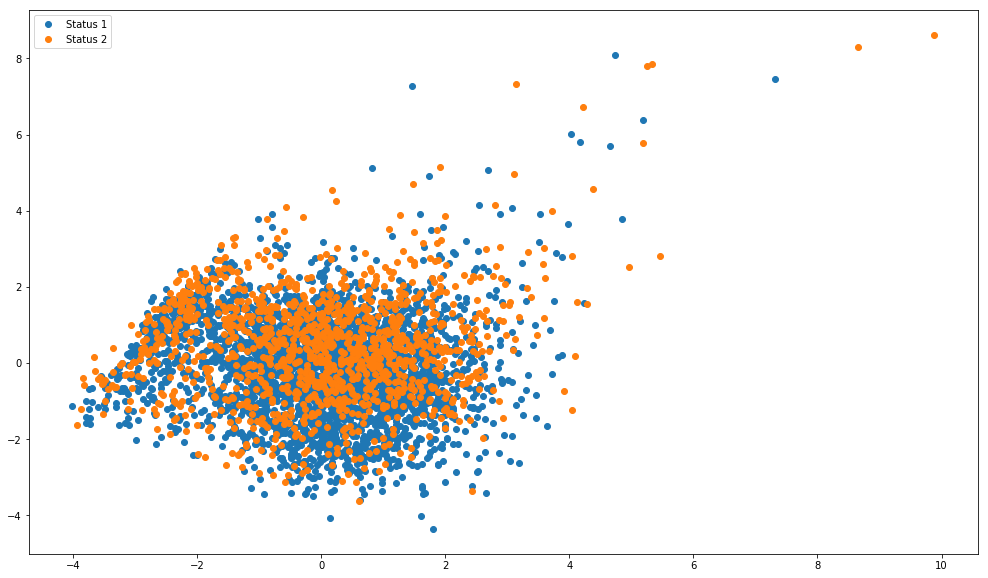

In [13]:
plt.figure(figsize=(17,10))

for u in sorted(y.unique()):
    ix = np.argwhere(y == u).squeeze()
    plt.plot(X_pca[ix, 0], X_pca[ix, 1], 'o', label='Status {}'.format(u))

plt.legend();

In [14]:
for i, component in enumerate(pca.components_):
    print("Component #{}: {:.2f}% of initial variance".format(i + 1, 100 * pca.explained_variance_ratio_[i], 2))

Component #1: 16.51% of initial variance
Component #2: 14.39% of initial variance


_Как можно видеть, по двум компонентам классы плохо разделимы_.

## 1. _Hyperparams_ 

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [16]:
X_pca_train, X_pca_test, X_norm_train, X_norm_test, X_train, X_test, y_train, y_test = \
    train_test_split(X_pca, X_norm, X, y, train_size=0.8)

print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)

(3563, 13) (3563,)
(891, 13) (891,)


In [17]:
%%time

tree = DecisionTreeClassifier()

tree_grid_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(5, 10)),
    'max_features': [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    'min_samples_leaf': list(range(3, 20))
}

gs = GridSearchCV(tree, tree_grid_params, scoring='f1', cv=5, n_jobs=4)
gs.fit(X_train, y_train)

best_tree = gs.best_estimator_

Wall time: 29 s


In [18]:
best_tree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=0.7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## 2. _Quality metrics_ 

In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

In [20]:
y_tree_pred = best_tree.predict(X_test)

In [21]:
print('[DecisionTree] F1 score best (train): {:.5f}'.format(gs.best_score_))
print('[DecisionTree] F1 score for best (test): {:.5f}'.format(f1_score(y_tree_pred, y_test)))
print('*' * 40)
print()

print('[DecisionTree] accuracy (test): {:.5f}'.format(accuracy_score(y_tree_pred, y_test)))
print('*' * 40)
print()

print('[DecisionTree] R2 (test): {:.5f}'.format(r2_score(y_tree_pred, y_test)))
print('*' * 40)

[DecisionTree] F1 score best (train): 0.85070
[DecisionTree] F1 score for best (test): 0.83891
****************************************

[DecisionTree] accuracy (test): 0.76207
****************************************

[DecisionTree] R2 (test): -0.30380
****************************************


### _2.1 Metric selection_

_[TODO]_

## 3. _Quality assessment_

### _3.1_

_[TODO]_

### _3.2 Comparison with SVM_

_Сравним качаество предсказаний с SVM_.

In [22]:
from sklearn.svm import SVC

In [23]:
%%time

svc = SVC()

svc_grid_params = {
    'C' : [0.1, 0.5, 1.0, 10.],
    'kernel' : ['linear', 'rbf']
}

gs = GridSearchCV(svc, svc_grid_params, scoring='f1', cv=5)
gs.fit(X_norm_train, y_train)

best_svc = gs.best_estimator_

Wall time: 18 s


In [24]:
best_svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [25]:
y_svc_pred = best_svc.predict(X_norm_test)

In [26]:
print('[SVC] F1 score best (train): {:.5f}'.format(gs.best_score_))
print('[SVC] F1 score for best (test): {:.5f}'.format(f1_score(y_svc_pred, y_test)))
print('*' * 40)
print()

print('[SVC] accuracy (test): {:.5f}'.format(accuracy_score(y_svc_pred, y_test)))
print('*' * 40)
print()

print('[SVC] R2 (test): {:.5f}'.format(r2_score(y_svc_pred, y_test)))
print('*' * 40)

[SVC] F1 score best (train): 0.84794
[SVC] F1 score for best (test): 0.85214
****************************************

[SVC] accuracy (test): 0.76319
****************************************

[SVC] R2 (test): -1.31631
****************************************


_Если судить по метрикам качества, то DecisionTree и SVC показывают примерно одинаковую точность предсказаний на данном датасете_.

## 4. _Max depth and overfitting_ 

_[TODO]_

## 5. _Visualization_

In [27]:
def plot_real_vs_predicted(X, y_test, y_pred):
    plt.figure(figsize=(17,10))
    
    def subplot(nrc, title, X, y):
        plt.subplot(nrc)
        plt.title(title)
        for u in sorted(np.unique(y)):
            ix = np.argwhere(y == u).squeeze()
            plt.scatter(X[ix, 0], X[ix, 1], label='Status {}'.format(u))
        plt.legend(loc=4)
        
    subplot(121, 'Real', X, y_test)
    subplot(122, 'Predicted', X, y_pred)

### _5.1 Decision Tree_

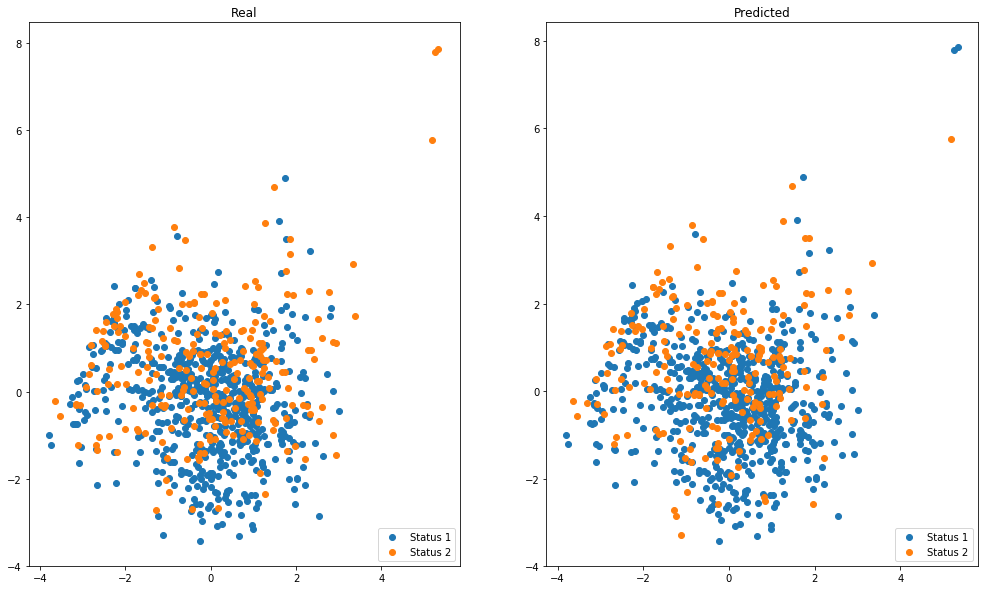

In [28]:
plot_real_vs_predicted(X_pca_test, y_test, y_tree_pred);

### _5.2 SVC_ 

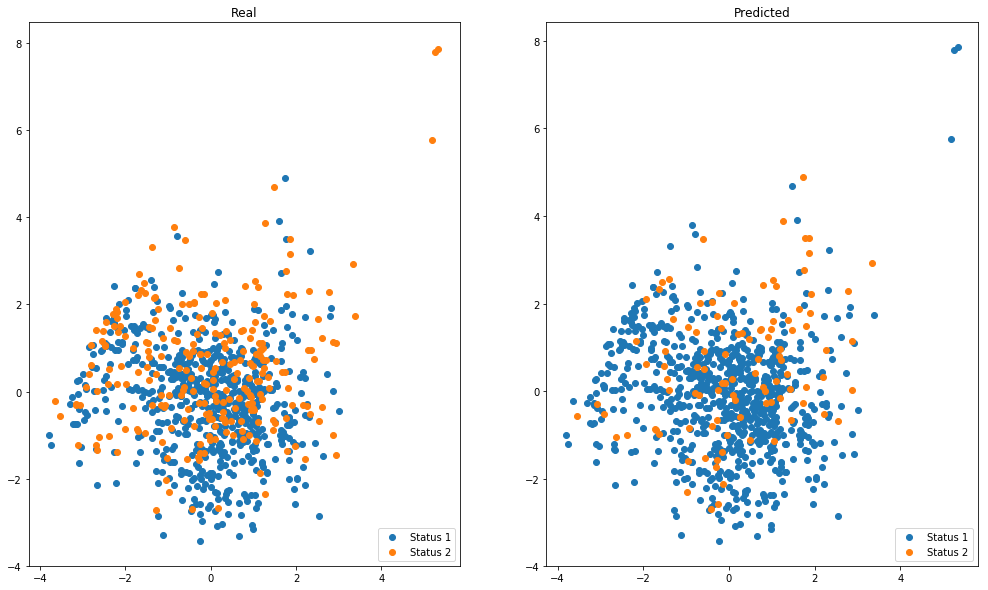

In [29]:
plot_real_vs_predicted(X_pca_test, y_test, y_svc_pred);

_SVC явно хуже предсказывает Status __2__. При этом на score это существенно не повлияло, очевидно, по причине того, что объектов Status **1** в выборке более чем в 2 раза больше_.


## 6. _graphviz_

In [30]:
from sklearn.tree import export_graphviz

In [31]:
export_graphviz(best_tree, out_file='tree.dot', filled=True, feature_names=X.columns)

In [33]:
from IPython.display import HTML
from IPython.display import display
display(HTML(filename='tree.html'));

[tree.html](tree.html)